## Машинное обучение в бизнесе
### Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

Этот набор данных случайным образом собирается из базы данных иранской телекоммуникационной компании в течение 12 месяцев.

In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


df = pd.read_csv("Customer Churn.csv")
print(df.shape)
df.head()

(3150, 14)


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [65]:
df['Tariff Plan'].value_counts(ascending=True)

2     245
1    2905
Name: Tariff Plan, dtype: int64

In [66]:
df['Status'].value_counts(ascending=True)

2     782
1    2368
Name: Status, dtype: int64

In [67]:
features = ['Call  Failure', 'Complains', 'Seconds of Use', 'Age', 'Age Group', 'Tariff Plan', 'Status', 'Customer Value']
target = "Churn"

# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)

In [68]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


continuous_columns = ['Call  Failure', 'Complains', 'Seconds of Use', 'Age', 'Age Group', 'Tariff Plan', 'Status', 'Customer Value']
final_transformers = list()

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

In [69]:
regressor = Pipeline([
    ('features', feats),
    ('regressor', LinearRegression()),
])

In [70]:
# обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Call  Failure',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Call  '
                                                                                     'Failure')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('Complains',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Complains')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('Seconds of Use',


In [71]:
predictions = regressor.predict(X_test)

mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.17339191861337536, 0.4123781432432425)

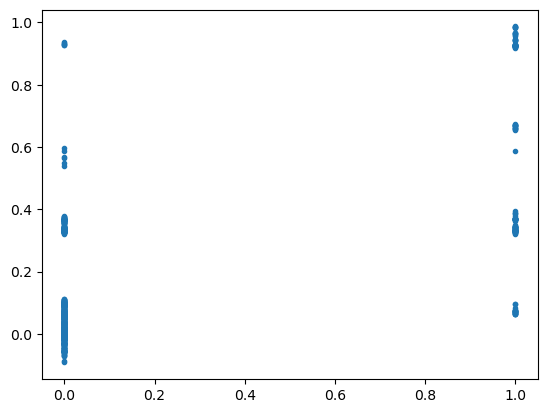

In [72]:
import matplotlib.pyplot as plt

plt.plot(y_test, predictions, '.')
plt.show()